## Data analysis

In [3]:
from l_p2 import persistence_length
import matplotlib.pyplot as plt
import numpy as np
import scipy
import MDAnalysis as mda
from MDAnalysis.analysis import polymer
import glob
import pandas as pd
from scipy.stats import linregress
import os
from polymer_dictionary import polymer_dictionary
from pl_com import persistence_length1

ref_length = 0.3563594872561357

In [7]:
# Getting a sorted list of the 10mer trajectories
key_list = sorted(list(polymer_dictionary.keys())) # Aligning dictionary and path to aid automation
path = os.getcwd() # Non-user specific path
molecule_list = sorted(glob.glob(path+"/gsd_files/10_mers/"+"*_10mer.gsd"))
p_lens = []

### Calculating persistence lengths:

In [8]:
for i in range(len(molecule_list)):
    print(molecule_list[i])
    h = persistence_length1(filepath=molecule_list[i],
                       # atom_index=polymer_dictionary.get(key_list[i]).get("Sulfur index"),
                       monomer_count=10,
                       start=1)
    l_p = h[0]
    l_b = h[1]
    x_values = h[2]
    C_n = h[3]
    exp_fit = h[4]
    decorr = h[-2]
    p_lens.append(l_p*ref_length*10)

/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTFBT_C11_BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTFBT_C1_BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTFBT_C3_BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTFBT_C4_BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTFBT_C5_BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTPT_HD_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTPT_ODD_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PCPDTPT_nC16_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PIDTBT_nC16_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PIDTCPDT_C11BO_10mer.gsd
/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/PIDTFBT_C11_BO_10mer.gsd


persistence length: 1.329498993214012 ang


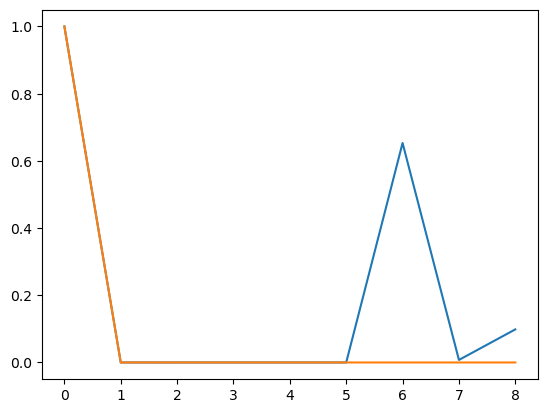

In [4]:
print('persistence length:',l_p*ref_length*10, 'ang')
plt.plot(C_n)
plt.plot(exp_fit)

## Comparison against Danielsen et al. paper

In [12]:
print(key_list)

['PCPDTFBT_C11_BO', 'PCPDTFBT_C1_BO', 'PCPDTFBT_C3_BO', 'PCPDTFBT_C4_BO', 'PCPDTFBT_C5_BO', 'PCPDTPT_HD', 'PCPDTPT_ODD', 'PCPDTPT_eneODD', 'PCPDTPT_nC16', 'PCPDT_PT_eneHD', 'PIDTBT_nC16', 'PIDTCPDT_C11BO', 'PIDTFBT_C11_BO']


In [9]:
measured_pl = [291, 67.0, 78.4, 86.4, 114, 47.3, 54.9, 83.4, 61.0, 76.6, 1310, 236, 254] # Measured persistence length using SANS (in alphabetical order)

In [6]:
differences = np.array(measured_pl) - np.array(p_lens)

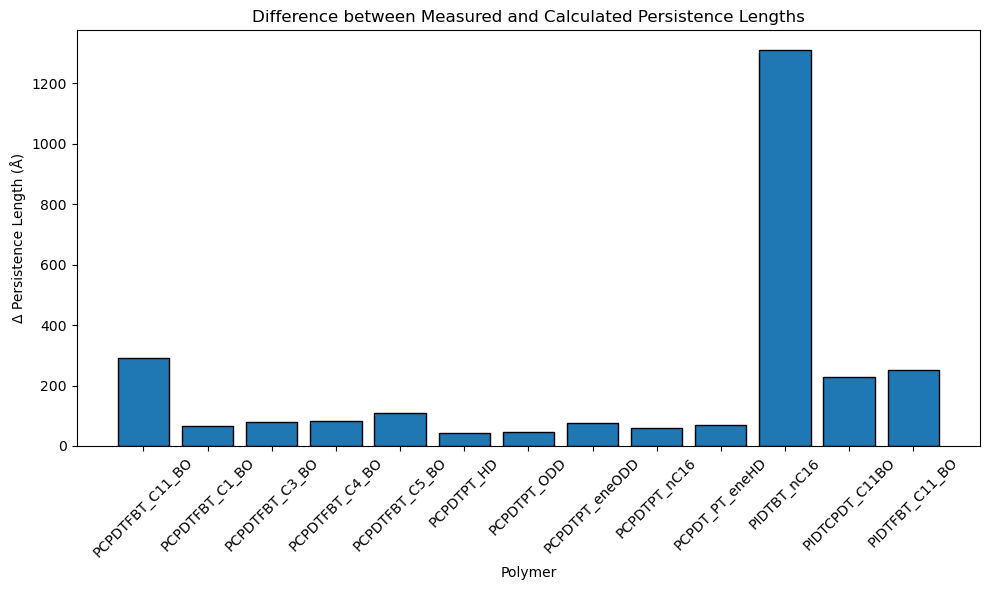

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(key_list, differences, edgecolor='black')

plt.xlabel('Polymer')
plt.ylabel('Δ Persistence Length (Å)')
plt.title('Difference between Measured and Calculated Persistence Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
temp = measured_pl[0:7]
temp2 = measured_pl[8:9]
measured_pl = measured_pl[10:] + temp + temp2

In [14]:
data = {"Polymer": molecule_list, "Persistence length (Å)": p_lens, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data)

In [15]:
print(df)

                                              Polymer  Persistence length (Å)  \
0   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...               11.374383   
1   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...               34.976074   
2   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...               37.458801   
3   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...               29.446479   
4   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...               27.443770   
5   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                3.668803   
6   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                6.740715   
7   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                3.284087   
8   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                0.760312   
9   /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                8.204815   
10  /home/jbieri/CME_lab/repos/pl-validation/gsd_f...                1.205590   

    Measured length (Å)  
0

In [10]:
data = {"Polymer": key_list, "Persistence length (Å)": p_lens, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data)

ValueError: All arrays must be of the same length

In [ ]:
print(df)

In [ ]:
import MDAnalysis.coordinates.GSD as gsd_reader
from grits import utils
import gsd.hoomd

In [7]:
l_p, l_b, x, auto_avg, fit, exp_coeff, acorr, decor, unit_bonds = persistence_length(
    filepath="PCPDTFBT_C4_BO_10mer_linear_test.gsd", 
    atom_index=23,        
    monomer_count=10
)

In [8]:
print(l_p*ref_length*10)

3089.807112880733


In [16]:
kb = 1.3806*10**-23

In [13]:
print(key_list)

['PCPDTFBT_C11_BO', 'PCPDTFBT_C1_BO', 'PCPDTFBT_C3_BO', 'PCPDTFBT_C4_BO', 'PCPDTFBT_C5_BO', 'PCPDTPT_HD', 'PCPDTPT_ODD', 'PCPDTPT_eneODD', 'PCPDTPT_nC16', 'PCPDT_PT_eneHD', 'PIDTBT_nC16', 'PIDTCPDT_C11BO', 'PIDTFBT_C11_BO']


In [14]:
epsilons = [1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046]

In [37]:
temperatures = [252, 503, 1006]
t252 = []
t503 = []
t1006 = []
T = []
for temp in temperatures:
    for i in epsilons:
        T.append((temp*kb)/1.046)

In [38]:
t252 = (T[0:int(len(T)/3)])
t503 = (T[int(len(T)/3):2*int(len(T)/3)])
t1006 = (T[2*int(len(T)/3):])

In [39]:
print(t252)

[3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21, 3.3261108986615677e-21]
